In [ ]:
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import numpy as np
import pandas as pd
import sounddevice as sd
import helpers as hp
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
import librosa
import librosa.feature
from feature_extraction import pytorch_models as tm
import optuna
import torch
SR = 44100
import imp
import joblib

drum_names = ['hat', 'kick', 'shake', 'snare']
optuna.logging.set_verbosity(0)



Load models

In [ ]:
imp.reload(tm)
cnet_dvn = tm.Transformer_DVN(attention_dropout=0.3,d_model=120,heads=30,encoding_layers=12,pool_dim=2,)
cnet_dvn = cnet_dvn.load_from_checkpoint(
    "models/transformer/DVNepoch=41-val_accuracy=0.991-val_loss=0.048.ckpt")

cnet_dvd = tm.Transformer_DVD(attention_dropout=0.3,d_model=100,heads=20,encoding_layers=12,pool_dim=1,pct_start=0.05,max_lr=1e-4,max_momentum=0.95,epochs=50)
cnet_dvd = cnet_dvd.load_from_checkpoint(
    "models/transformer/DVDepoch=59-val_accuracy=0.917-val_auc=0.9779-val_loss=0.327.ckpt")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
cnet_dvn.to(device)
cnet_dvd.to(device)
pass

In [282]:
# run an optuna trial for a drum type
estimators = ["HyperBand"]
drum_types = [0,1,2,3]
global drum_we_want
def objective(trial,):
    print(trial.number,end="\r")

    program = pg.StackParams()
    program.oscType = trial.suggest_categorical("OSC Type", [0,1,2])
    program.isNoise = trial.suggest_categorical("Noise Cloud", [0,1])
    
    program.A = trial.suggest_categorical("A", [0,1,2,3])
    program.D = trial.suggest_categorical("D", [0,1,2,3])
    program.S = trial.suggest_categorical("S", [0,1,2,3])
    program.R = trial.suggest_categorical("R", [0,1,2,3])
    
    program.pitch_0 = trial.suggest_categorical("pitch_0", range(0,120))
    program.pitch_1 = trial.suggest_categorical("pitch_1", range(0,120))
    program.pitch_2 = trial.suggest_categorical("pitch_2", range(0,120))
    program.pitch_3 = trial.suggest_categorical("pitch_3",range(0,120))
    
    program.bpCutLow = trial.suggest_categorical('High Cut', range(0,120))
    program.bpCutHigh = trial.suggest_categorical('Low Cut', range(0,120))
    program.bpOrder = trial.suggest_categorical("BP Order", [0,1,2])
    
    program.amplitude = trial.suggest_categorical("Amplitude", [0.3,0.5,0.8,1])
    
    program.start = trial.suggest_categorical("Start",  range(0,10))
    program.length = trial.suggest_categorical("Length", range(0,10))

    try:
        # make the sound 
        out = dsp.buffer(length=1,channels=1)
        s = pg.Synth(program)
        out.dub(s.buff,p.getStart())
        out = fx.norm(out,1)
        sound = hp.memToAud(out)
        # analyze it
        cnet_dvn.eval(),cnet_dvd.eval()
        with torch.no_grad():
            signal = torch.tensor(librosa.resample(sound.reshape(-1),SR,SR//2)).to(device)[0:SR//4].reshape(1,-1)
            score_dvn = cnet_dvn(signal).item()
    except Exception as e:
        return -1
    if score_dvn<0:
        return -0.5
    else:
        global drum_we_want 
        score_dvd = cnet_dvd(signal)[0][drum_we_want].item()
        return 1/(1 + np.exp(-score_dvd))

for e in estimators:
    for dt in drum_types:
        global drum_we_want 
        study_name = "%s_%s"%(e,drum_names[dt])
        drum_we_want = dt
        
        if e == "HyperBand":
            study_sampler = optuna.samplers.TPESampler(n_startup_trials=3000, n_ei_candidates=10,multivariate=True, )
        else:
            study_sampler = optuna.samplers.TPESampler(n_startup_trials=5000, n_ei_candidates=24,)
        study = optuna.create_study(
            study_name = study_name,
            sampler = study_sampler,
            #sampler = optuna.samplers.TPESampler(n_startup_trials=2000,),
#             load_if_exists=False, 
            directions=["maximize",],
            )
        study.optimize(objective, n_trials=5000, n_jobs=2),
        joblib.dump(study, "studies/%s_study.pkl"%study_name)


/home/asalimi/miniconda3/lib/python3.7/site-packages/optuna/study.py:398: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.



In [267]:
# let's sample from the probability distribution
params = study.sampler.sample_relative(study,optuna.trial._frozen.FrozenTrial,optuna.samplers.intersection_search_space(study))
program = pg.StackParams()
program.__dict__ = dict(zip(program.__dict__.keys(),params.values()))
# program.__dict__

out = dsp.buffer(length=1,channels=1)
s = pg.Synth(program)
out.dub(s.buff,program.getStart())
out = fx.norm(out,1)
sound = hp.memToAud(out)
Audio(sound,rate=SR, autoplay=True)

In [234]:
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


In [248]:
study = joblib.load("TPE_kick_study.pkl")

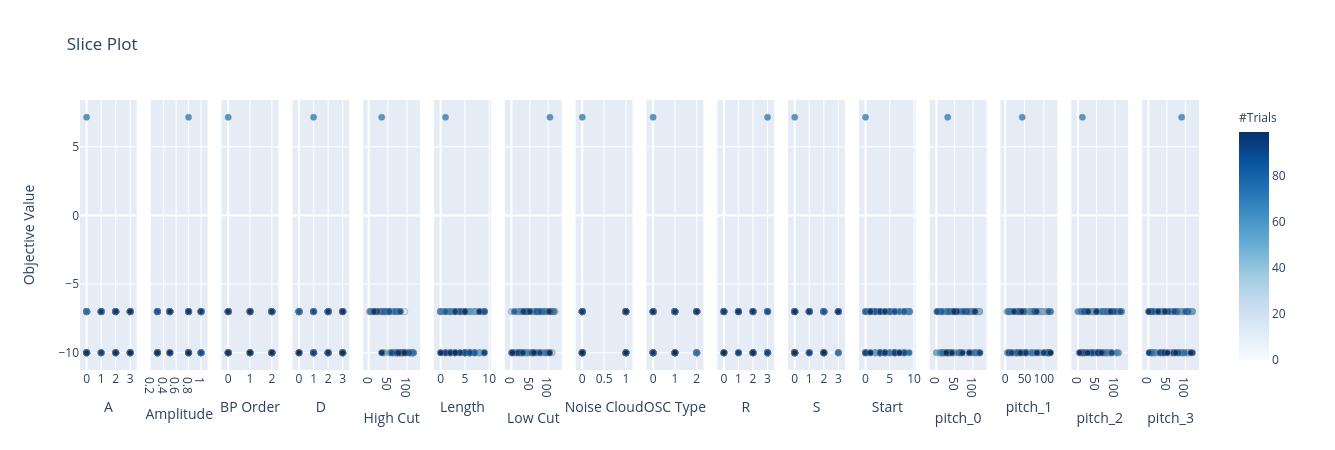

In [249]:
plot_slice(study)

In [57]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_A,params_Amplitude,params_BP Order,params_D,params_High Cut,...,params_Noise Cloud,params_OSC Type,params_R,params_S,params_Start,params_pitch_0,params_pitch_1,params_pitch_2,params_pitch_3,state
0,0,-10.0,2021-08-01 20:30:40.334498,2021-08-01 20:30:40.372950,00:00:00.038452,2,0.8,0,0,27,...,0,0,3,3,4,29,104,27,15,COMPLETE
1,1,-10.0,2021-08-01 20:30:40.372983,2021-08-01 20:30:40.378490,00:00:00.005507,2,1.0,0,2,86,...,1,2,2,0,6,6,64,15,20,COMPLETE
2,2,-10.0,2021-08-01 20:30:40.378519,2021-08-01 20:30:40.412010,00:00:00.033491,1,0.8,0,2,21,...,1,1,3,3,5,92,47,8,37,COMPLETE
3,3,-10.0,2021-08-01 20:30:40.412053,2021-08-01 20:30:40.445952,00:00:00.033899,1,0.5,0,3,5,...,0,0,2,0,4,30,75,30,93,COMPLETE
4,4,-10.0,2021-08-01 20:30:40.445996,2021-08-01 20:30:40.480163,00:00:00.034167,2,0.5,0,3,45,...,1,0,2,0,8,23,39,69,28,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,-10.0,2021-08-01 20:32:36.023432,2021-08-01 20:32:36.118412,00:00:00.094980,1,1.0,2,2,21,...,0,2,3,0,7,0,112,114,33,COMPLETE
1996,1996,-10.0,2021-08-01 20:32:36.119217,2021-08-01 20:32:36.185566,00:00:00.066349,0,1.0,2,1,98,...,0,1,3,0,2,104,114,98,110,COMPLETE
1997,1997,-10.0,2021-08-01 20:32:36.186317,2021-08-01 20:32:36.253685,00:00:00.067368,0,1.0,2,2,62,...,0,1,3,0,4,112,30,52,89,COMPLETE
1998,1998,-10.0,2021-08-01 20:32:36.254427,2021-08-01 20:32:36.349866,00:00:00.095439,0,1.0,2,2,61,...,0,2,3,0,4,0,60,8,17,COMPLETE
